In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy.stats as sps
import pprint as pp
from datetime import datetime

In [2]:
# Find repo root (folder containing pyproject.toml)
root = Path.cwd()
while not (root / "pyproject.toml").exists() and root.parent != root:
    root = root.parent

sys.path.insert(0, str(root))  # so `src.*` becomes importable
sys.path.append(os.path.abspath("../../src"))

In [3]:
from src.cross_sell_lift_payment_services.preprocessing import load_raw_data
from src.cross_sell_lift_payment_services.helpers import (eligible_incentives, 
                                                          variants_discounts,
                                                          agg_attach_accepted_paid,
                                                          bootstrap_ci,
                                                          chi_independence_test,
                                                          proportions_z_test, 
                                                          has_item,
                                                          wald_test)

In [4]:
# pandas config options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Data Loading

In [5]:
results = load_raw_data("s3://dsml-projects/cross-sell/raw_data_for_model/")

In [6]:
# Loading data from S3 using the load_raw_data function created in the preprocessing_utils module
df_merchants = results['merchants']
df_cart_events = results['cart_events']
df_cart_incentives = results['cart_incentives']
df_activity_events = results['activity_events']

In [7]:
print("Merchants dataset: \n", df_merchants.shape)
print("-"*100)
print("Cart Events dataset: \n", df_cart_events.shape)
print("-"*100)
print("Cart incentives dataset: \n", df_cart_incentives.shape)
print("-"*100)
print("Activity events dataset: \n", df_activity_events.shape)

Merchants dataset: 
 (6000, 14)
----------------------------------------------------------------------------------------------------
Cart Events dataset: 
 (30000, 11)
----------------------------------------------------------------------------------------------------
Cart incentives dataset: 
 (15582, 20)
----------------------------------------------------------------------------------------------------
Activity events dataset: 
 (120000, 15)


In [8]:
print("Merchants dataset: \n", df_merchants.head(5))
print("-"*100)
print("Cart Events dataset: \n", df_cart_events.head(5))
print("-"*100)
print("Cart incentives dataset: \n", df_cart_incentives.head(5))
print("-"*100)
print("Activity events dataset: \n", df_activity_events.head(5))

Merchants dataset: 
   merchant_id legal_form             mcc  uf sales_channel preferred_contact_channel onboarding_date  kyc_tier employee_count_band city_size_band  has_pix_enabled  has_payment_link_enabled  has_antecipacao_enabled  has_conta_pj
0     M000000        MEI          beauty  PE        hybrid                     phone      2022-11-09         1                6-10          large                0                         1                        0             1
1     M000001        MEI  retail_fashion  BA     in_person                     email      2023-05-10         1                6-10          large                1                         1                        0             1
2     M000002       LTDA  retail_fashion  PR        hybrid                     email      2022-11-07         2                 3-5          large                0                         0                        0             1
3     M000003        MEI    food_service  DF     in_person         

# Preprocessing Steps

In [9]:
df_cart_events["primary_product"] = df_cart_events["products"].apply(lambda s: str(s).split("|")[0] if isinstance(s, str) else None)

In [10]:
df_cart_events ['merchant_cart_id'] = df_cart_events['merchant_id'] + "_" + df_cart_events['cart_id'].astype(str)
df_cart_incentives ['merchant_cart_id'] = df_cart_incentives['merchant_id'] + "_" + df_cart_incentives['cart_id'].astype(str)

In [11]:
merch_carts_incs = df_cart_incentives.merge(df_cart_events[['merchant_cart_id', 
                                                            'primary_product',
                                                            "payment_finalized",
                                                            "cart_value",
                                                            "device_type",
                                                            "payment_method_selected",
                                                            "funnel_step",
                                                            "timestamp" ]], on='merchant_cart_id', how='left', suffixes=("","_cevents"))\
                                     .rename(columns={'timestamp': 'cart_timestamp'})\
                                     .merge(df_merchants, on='merchant_id', how='left', suffixes=("","_merchs"))

In [12]:
print(merch_carts_incs.shape)
merch_carts_incs.head(3)

(15582, 41)


,incentive_id,cart_id,merchant_id,cart_timestamp,placement,incentive_type,candidate_addon,incentive_variant,clicked,accepted,incentive_cost_if_accepted,margin_if_accepted,cart_products,cart_quantities,cart_unit_prices,cart_value,funnel_step,device_type,payment_finalized,payment_method_selected,merchant_cart_id,primary_product,payment_finalized_cevents,cart_value_cevents,device_type_cevents,payment_method_selected_cevents,funnel_step_cevents,timestamp_cevents,legal_form,mcc,uf,sales_channel,preferred_contact_channel,onboarding_date,kyc_tier,employee_count_band,city_size_band,has_pix_enabled,has_payment_link_enabled,has_antecipacao_enabled,has_conta_pj
0,INC0000000,C0008888,M002387,2025-03-03 19:07:00,bundle_box,copy,CONTA_PJ,copy_reminder_conta,0,0,0.0,30.0,Extra_POS,1,199.0,199.0,shipping,mobile_app,0,boleto,M002387_C0008888,Extra_POS,0,199.0,mobile_app,boleto,shipping,2025-03-03 18:56:00,LTDA,beauty,SP,hybrid,app_inbox,2024-05-17,2,21+,medium,0,0,0,0
1,INC0000001,C0008888,M002387,2025-03-03 19:10:00,bundle_box,popup,CONTA_PJ,monthly_fee_waived_3m,1,0,15.0,30.0,Extra_POS,1,199.0,199.0,shipping,mobile_app,0,boleto,M002387_C0008888,Extra_POS,0,199.0,mobile_app,boleto,shipping,2025-03-03 18:56:00,LTDA,beauty,SP,hybrid,app_inbox,2024-05-17,2,21+,medium,0,0,0,0
2,INC0000002,C0009629,M005416,2025-06-06 08:08:00,payment_moment,copy,PIX_QR,pix_free_first_100,1,0,12.0,50.0,Ton_Super|Extra_POS,1|1,249.0|199.0,448.0,plan_selection,desktop_web,1,pix,M005416_C0009629,Ton_Super,1,448.0,desktop_web,pix,plan_selection,2025-06-06 08:03:00,LTDA,retail_fashion,PR,online,app_inbox,2022-11-23,1,1-2,medium,0,0,1,1


In [13]:
merch_carts_incs_exposure = merch_carts_incs
merch_carts_incs_exposure['eligible_incentive'] = merch_carts_incs_exposure.apply(eligible_incentives, axis=1)
merch_carts_incs_exposure['treatment'] = merch_carts_incs_exposure["incentive_variant"].isin(variants_discounts).astype(int)
merch_carts_incs_exposure.head(5)

,incentive_id,cart_id,merchant_id,cart_timestamp,placement,incentive_type,candidate_addon,incentive_variant,clicked,accepted,incentive_cost_if_accepted,margin_if_accepted,cart_products,cart_quantities,cart_unit_prices,cart_value,funnel_step,device_type,payment_finalized,payment_method_selected,merchant_cart_id,primary_product,payment_finalized_cevents,cart_value_cevents,device_type_cevents,payment_method_selected_cevents,funnel_step_cevents,timestamp_cevents,legal_form,mcc,uf,sales_channel,preferred_contact_channel,onboarding_date,kyc_tier,employee_count_band,city_size_band,has_pix_enabled,has_payment_link_enabled,has_antecipacao_enabled,has_conta_pj,eligible_incentive,treatment
0,INC0000000,C0008888,M002387,2025-03-03 19:07:00,bundle_box,copy,CONTA_PJ,copy_reminder_conta,0,0,0.0,30.0,Extra_POS,1,199.0,199.0,shipping,mobile_app,0,boleto,M002387_C0008888,Extra_POS,0,199.0,mobile_app,boleto,shipping,2025-03-03 18:56:00,LTDA,beauty,SP,hybrid,app_inbox,2024-05-17,2,21+,medium,0,0,0,0,True,0
1,INC0000001,C0008888,M002387,2025-03-03 19:10:00,bundle_box,popup,CONTA_PJ,monthly_fee_waived_3m,1,0,15.0,30.0,Extra_POS,1,199.0,199.0,shipping,mobile_app,0,boleto,M002387_C0008888,Extra_POS,0,199.0,mobile_app,boleto,shipping,2025-03-03 18:56:00,LTDA,beauty,SP,hybrid,app_inbox,2024-05-17,2,21+,medium,0,0,0,0,True,1
2,INC0000002,C0009629,M005416,2025-06-06 08:08:00,payment_moment,copy,PIX_QR,pix_free_first_100,1,0,12.0,50.0,Ton_Super|Extra_POS,1|1,249.0|199.0,448.0,plan_selection,desktop_web,1,pix,M005416_C0009629,Ton_Super,1,448.0,desktop_web,pix,plan_selection,2025-06-06 08:03:00,LTDA,retail_fashion,PR,online,app_inbox,2022-11-23,1,1-2,medium,0,0,1,1,True,1
3,INC0000003,C0005317,M005205,2025-07-29 06:52:00,bundle_box,copy,ANTECIPACAO,antec_discount_30bps,0,0,18.0,80.0,Stone_Flex,1,0.0,0.0,checkout,desktop_web,0,card,M005205_C0005317,Stone_Flex,0,0.0,desktop_web,card,checkout,2025-07-29 06:44:00,EIRELI,retail_fashion,MG,in_person,whatsapp,2022-09-03,3,1-2,small,1,0,0,0,True,1
4,INC0000004,C0007829,M005441,2025-06-19 20:49:00,cart_side_panel,copy,PAYMENT_LINK,link_zero_fee_first_10,0,0,8.0,40.0,Extra_POS,1,199.0,199.0,plan_selection,mobile_app,1,link,M005441_C0007829,Extra_POS,1,199.0,mobile_app,link,plan_selection,2025-06-19 20:45:00,LTDA,grocery,RJ,online,whatsapp,2023-08-25,3,11-20,medium,1,1,0,0,False,1


In [14]:
important_cols = {
    "merchants": ["legal_form","mcc","uf","sales_channel","kyc_tier","has_pix_enabled","has_payment_link_enabled","has_antecipacao_enabled","has_conta_pj"],
    "carts": ["products","cart_value","payment_finalized","device_type","payment_method_selected","funnel_step"],
    "incs": ["candidate_addon","incentive_variant","placement","incentive_type","clicked","accepted"]
}

### General Stats

In [15]:
print("Null analysis in the datasets")
nulls = {}
for tbl, cols in important_cols.items():
    df = {"merchants":df_merchants, "carts":df_cart_events, "incs":df_cart_incentives}[tbl]
    nulls[tbl] = {c: float(df[c].isna().mean()) for c in cols if c in df.columns}
printer = pp.PrettyPrinter(width=100, compact=False, sort_dicts=False)
printer.pprint(nulls)

Null analysis in the datasets
{'merchants': {'legal_form': 0.0,
               'mcc': 0.0,
               'uf': 0.0,
               'sales_channel': 0.0,
               'kyc_tier': 0.0,
               'has_pix_enabled': 0.0,
               'has_payment_link_enabled': 0.0,
               'has_antecipacao_enabled': 0.0,
               'has_conta_pj': 0.0},
 'carts': {'products': 0.0,
           'cart_value': 0.0,
           'payment_finalized': 0.0,
           'device_type': 0.0,
           'payment_method_selected': 0.0,
           'funnel_step': 0.0},
 'incs': {'candidate_addon': 0.0,
          'incentive_variant': 0.0,
          'placement': 0.0,
          'incentive_type': 0.0,
          'clicked': 0.0,
          'accepted': 0.0}}


In [16]:
exposed_carts_ratio = round(df_cart_incentives['cart_id'].nunique() / df_cart_events['cart_id'].nunique(), 2)
percentage_incentives_paid =  (merch_carts_incs['payment_finalized'] == 1).mean()
percentage_incentives_paid_events =  (merch_carts_incs['payment_finalized_cevents'] == 1).mean()
percentage_mchts_carts_events = df_merchants['merchant_id'].isin(df_cart_events['merchant_id']).mean()
percentage_mchts_carts_incentives = df_merchants['merchant_id'].isin(df_cart_incentives['merchant_id']).mean()

join_rates = {
    "exposed_cart_ratio": float(exposed_carts_ratio),
    "percentage_incentives_paid": float(percentage_incentives_paid),
    "percentage_incentives_paid_events": float(percentage_incentives_paid_events),
    "pct_merchants_present_in_events": float(percentage_mchts_carts_events),
    "pct_merchants_present_in_incentives": float(percentage_mchts_carts_incentives)
}

printer.pprint(join_rates)

{'exposed_cart_ratio': 0.4,
 'percentage_incentives_paid': 0.7244256193043255,
 'percentage_incentives_paid_events': 0.7244256193043255,
 'pct_merchants_present_in_events': 0.9941666666666666,
 'pct_merchants_present_in_incentives': 0.8675}


# 1. Business Understanding
## 1.1. Insights for product adoption:

#### 1.1.1. Baseline vs Discount performance
- How often merchants accept add-ons when no monetary discount is shown
- How often merchant accept add-ins when momentary discount is shown
- Is the difference between both statistics significant?

In [17]:
# identify if the incentive is a discount
merch_carts_incs['is_discount'] = merch_carts_incs['incentive_variant'].isin(variants_discounts)

In [18]:
g = (merch_carts_incs
     .groupby(["primary_product","candidate_addon","eligible_incentive","is_discount"])
     .agg(n=("accepted","size"), a=("accepted","sum"))
     .reset_index())

base = g[g["is_discount"]==0].rename(columns={"n":"n_a","a":"a"})
disc = g[g["is_discount"]==1].rename(columns={"n":"n_b","a":"b"})

wide = base.merge(disc, on=["primary_product","candidate_addon","eligible_incentive"], how="inner")

# taxas por braço
wide["p_a"] = wide["a"] / wide["n_a"]
wide["p_b"] = wide["b"] / wide["n_b"]

# diferença em p.p.
wide["delta_attach_pp"] = wide["p_b"] - wide["p_a"]

# só testa quando há amostra mínima suficiente em ambos os braços
min_n = 50
testable = wide[(wide["n_a"]>=min_n) & (wide["n_b"]>=min_n)].copy()



In [19]:
# z-test + ICs (usando suas funções)
rows = []
for _, r in testable.iterrows():
    zres = proportions_z_test(int(r["a"]), int(r["n_a"]), int(r["b"]), int(r["n_b"]))
    ci_a = wald_test(zres["prob_success_group_A"], int(r["n_a"]))
    ci_b = wald_test(zres["prob_success_group_B"], int(r["n_b"]))
    rows.append({
        "primary_product": r["primary_product"],
        "candidate_addon": r["candidate_addon"],
        "eligible_incentive": r["eligible_incentive"],
        "n_a": int(r["n_a"]), "a": int(r["a"]), "p_a": zres["prob_success_group_A"],
        "n_b": int(r["n_b"]), "b": int(r["b"]), "p_b": zres["prob_success_group_B"],
        "delta_attach_pp": r["delta_attach_pp"],
        "baseline_ci_lo": ci_a[0], "baseline_ci_hi": ci_a[1],
        "discount_ci_lo": ci_b[0], "discount_ci_hi": ci_b[1],
        "z": zres["z"], "pvalue": zres["p_value"],
    })

pair_stats_robust = (pd.DataFrame(rows)
                     .sort_values("delta_attach_pp", ascending=False)
                     .reset_index(drop=True))

display(pair_stats_robust.head(15))

,primary_product,candidate_addon,eligible_incentive,n_a,a,p_a,n_b,b,p_b,delta_attach_pp,baseline_ci_lo,baseline_ci_hi,discount_ci_lo,discount_ci_hi,z,pvalue
0,Stone_Flex,ANTECIPACAO,False,65,2,0.030769,89,12,0.134831,0.104062,0.000000,0.072751,0.063874,0.205789,-2.218590,0.026515
1,Ton_Pro,CONTA_PJ,True,152,4,0.026316,171,18,0.105263,0.078947,0.000868,0.051763,0.059265,0.151261,-2.811022,0.004938
2,Stone_Flex,PAYMENT_LINK,False,147,9,0.061224,124,16,0.129032,0.067808,0.022469,0.099980,0.070027,0.188037,-1.921746,0.054638
3,TapTon,ANTECIPACAO,True,175,7,0.040000,142,15,0.105634,0.065634,0.010967,0.069033,0.055079,0.156189,-2.286641,0.022217
4,Ton_Super,ANTECIPACAO,True,185,8,0.043243,196,21,0.107143,0.063900,0.013933,0.072554,0.063842,0.150443,-2.350738,0.018736
5,Ton_Pro,PAYMENT_LINK,False,298,15,0.050336,320,34,0.106250,0.055914,0.025512,0.075159,0.072487,0.140013,-2.570674,0.010150
6,TapTon,ANTECIPACAO,False,88,4,0.045455,89,9,0.101124,0.055669,0.001934,0.088975,0.038487,0.163760,-1.419525,0.155746
7,Ton_Super,EXTRA_POS,True,168,7,0.041667,181,17,0.093923,0.052256,0.011450,0.071883,0.051424,0.136421,-1.927504,0.053917
8,Ton_Super,PAYMENT_LINK,False,255,9,0.035294,242,21,0.086777,0.051483,0.012646,0.057942,0.051309,0.122244,-2.408788,0.016006
9,Ton_Pro,ANTECIPACAO,False,149,3,0.020134,154,11,0.071429,0.051294,0.000000,0.042687,0.030753,0.112104,-2.126333,0.033476


In [20]:
df = pair_stats_robust.copy()
df = df[df["eligible_incentive"] == True]  # or == 1 depending on your dtype

# Benjamini–Hochberg FDR correction (no external libs)
def fdr_bh(pvals):
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    q = np.empty(n, dtype=float)
    prev = 1.0
    for i in range(n-1, -1, -1):
        q[i] = min(prev, ranked[i] * n / (i+1))
        prev = q[i]
    q_adj = np.empty(n, dtype=float)
    q_adj[order] = q
    return q_adj

df["qvalue"] = fdr_bh(df["pvalue"].values)
df["significant"] = df["qvalue"] < 0.05
df["total_n"] = df["n_a"] + df["n_b"]


# Approx 95% CI for the *difference* in rates (delta_attach_pp)
p_pool = (df["a"] + df["b"]) / (df["n_a"] + df["n_b"])
se = np.sqrt(p_pool * (1 - p_pool) * (1/df["n_a"] + 1/df["n_b"]))
df["delta_lo"] = df["delta_attach_pp"] - 1.96 * se
df["delta_hi"] = df["delta_attach_pp"] + 1.96 * se

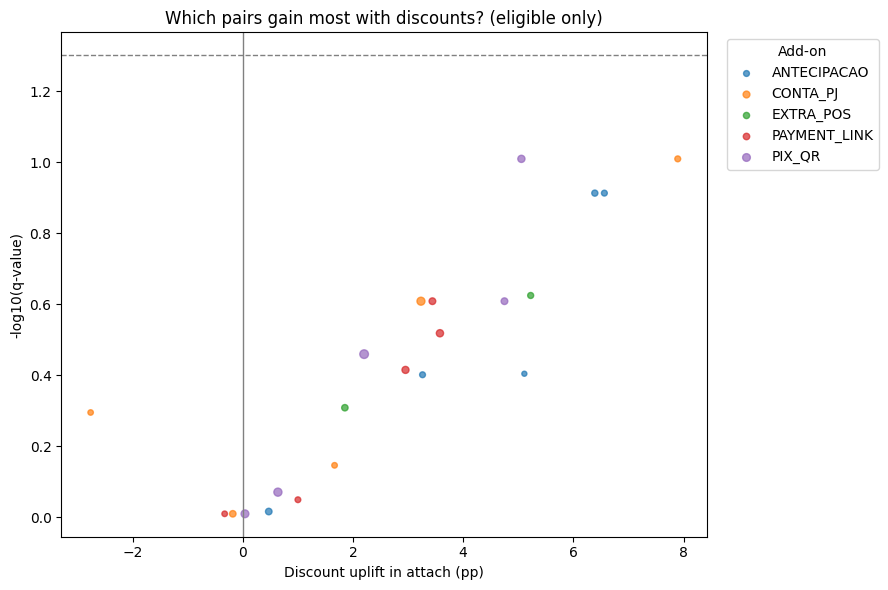

In [21]:
plt.figure(figsize=(9,6))
for addon, g in df.groupby("candidate_addon"):
    plt.scatter(
        g["delta_attach_pp"]*100,                        # turn to pp
        -np.log10(g["qvalue"].clip(lower=1e-300)),
        s=np.sqrt(g["total_n"]).clip(10, 200), alpha=0.7, label=addon
    )

plt.axvline(0, color="gray", lw=1)
plt.axhline(-np.log10(0.05), color="gray", lw=1, ls="--")
plt.xlabel("Discount uplift in attach (pp)")
plt.ylabel("-log10(q-value)")
plt.title("Which pairs gain most with discounts? (eligible only)")
plt.legend(title="Add-on", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### 1.1.2. Product pair basket (without incentives)
- Which products are bought together naturally? (pairwise lifts)
- Which recommendations do not require spending money

In [22]:
# removing cases that where exposed to incentives
exposed_cart_ids = set(df_cart_incentives['cart_id'].tolist())
basket = df_cart_events[~df_cart_events['cart_id'].isin(exposed_cart_ids)].copy()


In [23]:
#unique set of products
nested = (list(map(lambda x:x.split('|'), basket['products'].unique().tolist())))
flat = [item for sublist in nested for item in sublist]
flat = list(set(flat))
flat

['TapTon', 'Extra_POS', 'Ton_Pro', 'Stone_Flex', 'Ton_Super']

In [24]:
for base in flat:
    basket[f"has_{base}"] = basket['products'].apply(lambda x:has_item(x,base))
basket.head(5)

,cart_id,merchant_id,timestamp,products,quantities,unit_prices,cart_value,payment_method_selected,payment_finalized,device_type,funnel_step,primary_product,merchant_cart_id,has_TapTon,has_Extra_POS,has_Ton_Pro,has_Stone_Flex,has_Ton_Super
1,C0000001,M004309,2025-01-03 17:29:00,Extra_POS,1,199.0,199.0,pix,1,mobile_web,checkout,Extra_POS,M004309_C0000001,False,True,False,False,False
4,C0000004,M001930,2025-09-11 07:18:00,Ton_Super,1,249.0,249.0,card,1,mobile_app,plan_selection,Ton_Super,M001930_C0000004,False,False,False,False,True
5,C0000005,M002486,2025-08-10 18:15:00,Extra_POS|Ton_Super,1|1,199.0|249.0,448.0,card,1,desktop_web,plan_selection,Extra_POS,M002486_C0000005,False,True,False,False,True
6,C0000006,M001131,2025-09-27 22:23:00,TapTon|Stone_Flex,1|1,0.0|0.0,0.0,card,1,mobile_app,shipping,TapTon,M001131_C0000006,True,False,False,True,False
8,C0000008,M005593,2025-01-11 18:44:00,Ton_Pro|Extra_POS,1|1,299.0|199.0,498.0,card,1,desktop_web,plan_selection,Ton_Pro,M005593_C0000008,False,True,True,False,False


In [25]:
predfs = []
for base1 in range(len(flat)-1):
    rows = []
    for base2 in range(base1+1, len(flat)):
        sub = basket.copy()
        confidence = sub.loc[sub[f"has_{flat[base2]}"], f"has_{flat[base1]}"].mean()
        support = sub[f"has_{flat[base2]}"].mean()
        base_rate = sub[f"has_{flat[base1]}"].mean()
        lift = (confidence / base_rate) if base_rate > 0 else np.nan
        contingency = pd.crosstab(sub[f"has_{flat[base2]}"], sub[f"has_{flat[base1]}"]).values
        chi2, df, p = chi_independence_test(contingency, permutations = 1000 if sps is None else 0)
        rows.append({'base': flat[base2], 'confidence': confidence, 'support': support, 'lift': lift, 'chi2':chi2,'pvalue':p})
    df_ = pd.DataFrame(rows).sort_values("lift", ascending=False)
    df_['base_comp_product'] = flat[base1]
    df_ = df_[['base_comp_product','base','confidence','support','lift','chi2','pvalue']]
    predfs.append(df_)
df = pd.concat(predfs)

In [26]:
df

,base_comp_product,base,confidence,support,lift,chi2,pvalue
0,TapTon,Extra_POS,0.179595,0.252111,0.705522,179.680327,0.0
1,TapTon,Ton_Pro,0.078393,0.313944,0.307961,1347.082995,0.0
3,TapTon,Ton_Super,0.076104,0.250389,0.298968,1009.009239,0.0
2,TapTon,Stone_Flex,0.074559,0.207889,0.292899,806.580872,0.0
2,Extra_POS,Ton_Super,0.177280,0.250389,0.703181,178.562121,0.0
0,Extra_POS,Ton_Pro,0.176606,0.313944,0.700508,249.052374,0.0
1,Extra_POS,Stone_Flex,0.173704,0.207889,0.688997,154.028329,0.0
0,Ton_Pro,Stone_Flex,0.096740,0.207889,0.308143,1034.770787,0.0
1,Ton_Pro,Ton_Super,0.092301,0.250389,0.294004,1371.354589,0.0
0,Stone_Flex,Ton_Super,0.056135,0.250389,0.270024,840.841974,0.0


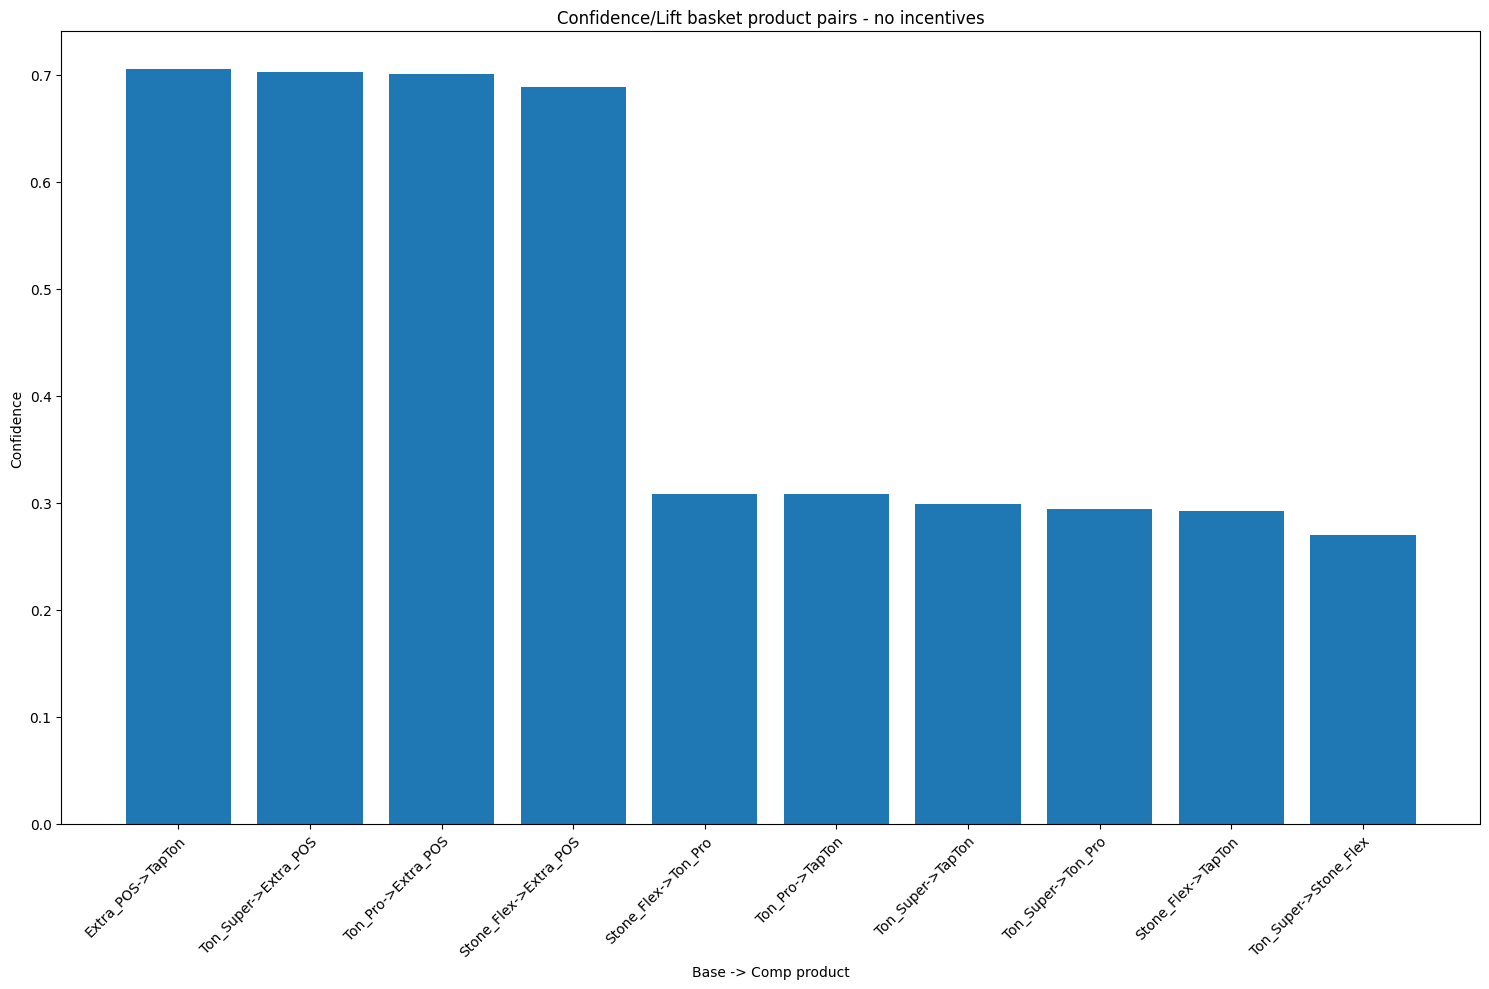

In [27]:
df = df.sort_values(by = "lift", ascending= False)
fig, ax = plt.subplots(figsize=(15, 10))

labels = df["base"] + "->" + df["base_comp_product"]
ax.bar(labels, df["lift"])

ax.set_title("Confidence/Lift basket product pairs - no incentives")
ax.set_ylabel("Confidence")
ax.set_xlabel("Base -> Comp product")

# put labels on a diagonal
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# (optional) make room if labels are long
plt.subplots_adjust(bottom=0.25)   # or use a larger value if needed
# ax.tick_params(axis='x', labelsize=9)  # shrink font if crowded

plt.tight_layout()
plt.show()


#### 1.1.3. Incentive Placement and format
           Where in the cart do exposures work best?

In [28]:
performance = df_cart_incentives.groupby(['candidate_addon', 'placement', 'incentive_type'])\
                         .agg(
                             exposures = ("incentive_id", "size"),
                             ctr = ("clicked", "mean"),
                             acceptance = ("accepted", "mean")
                         ).reset_index()

In [29]:
base_conversion = df_cart_events['payment_finalized'].mean()
paid_after_incentive_exposure = df_cart_incentives.groupby(['placement', 'incentive_type'])\
                                                  .apply(lambda g:((g['accepted'] == 1) & (g['payment_finalized'] == 1)).mean())\
                                                  .rename("paid_acceptance").reset_index()

C:\Users\castr\AppData\Local\Temp\ipykernel_22012\1879410630.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g:((g['accepted'] == 1) & (g['payment_finalized'] == 1)).mean())\


In [30]:
performance = performance.merge(paid_after_incentive_exposure, on = ['placement', 'incentive_type'], how = 'left')
performance.sort_values(by='paid_acceptance', ascending =False)


,candidate_addon,placement,incentive_type,exposures,ctr,acceptance,paid_acceptance
40,EXTRA_POS,checkout_modal,addon,25,0.240000,0.040000,0.109204
8,ANTECIPACAO,checkout_modal,addon,93,0.311828,0.107527,0.109204
24,CONTA_PJ,checkout_modal,addon,106,0.311321,0.141509,0.109204
56,PAYMENT_LINK,checkout_modal,addon,219,0.273973,0.105023,0.109204
72,PIX_QR,checkout_modal,addon,198,0.323232,0.106061,0.109204
...,...,...,...,...,...,...,...
62,PAYMENT_LINK,payment_moment,copy,212,0.103774,0.051887,0.050725
46,EXTRA_POS,payment_moment,copy,23,0.086957,0.043478,0.050725
30,CONTA_PJ,payment_moment,copy,115,0.121739,0.052174,0.050725
78,PIX_QR,payment_moment,copy,224,0.133929,0.062500,0.050725


In [31]:
# z testing to see acceptance significance across placements
tests = []
for addon, g in df_cart_incentives.groupby('candidate_addon'):
    for inc_type, gt in g.groupby('incentive_type'):
        options = gt['placement'].unique()
        for i in range(len(options)):
            for j in range( i+1, len(options)):
                p_i = options[i]; p_j = options[j]
                Gi = gt[gt['placement'] == p_i]
                Gj = gt[gt['placement'] == p_j]
                zresp = proportions_z_test(Gi['accepted'].sum(), len(Gi), Gj['accepted'].sum(), len(Gj))
                tests.append({
                    'addon': addon,
                    'incentive_type': inc_type,
                    'placement_i': p_i,
                    'placement_j': p_j,
                    'prob_success_placement_i': zresp['prob_success_group_A'],
                    'prob_success_placement_j': zresp['prob_success_group_B'],
                    'z': zresp['z'],
                    'pvalue': zresp['p_value']
                })
tests_df = pd.DataFrame(tests).sort_values(by='pvalue')


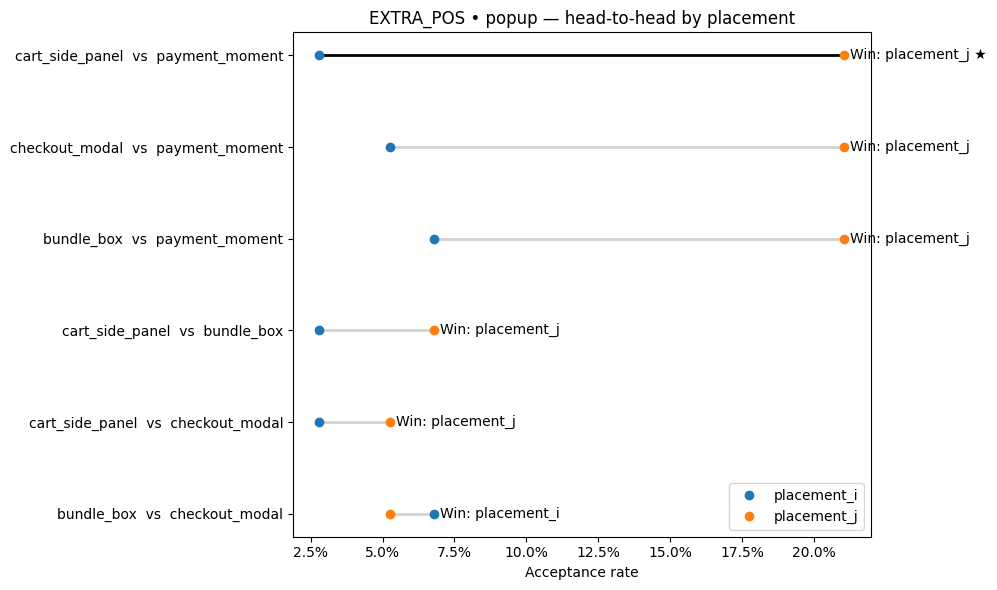

In [32]:
t = tests_df.copy()
t["delta"] = t["prob_success_placement_j"] - t["prob_success_placement_i"]
t["sig"] = t["pvalue"] < 0.05
t["pair"] = t["placement_i"] + "  vs  " + t["placement_j"]

# focus a slice (change as needed)
addon = "EXTRA_POS"; inc_type = "popup"
s = t[(t["addon"]==addon) & (t["incentive_type"]==inc_type)].sort_values("delta")

# --- plot
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(s))
x_i = s["prob_success_placement_i"].values
x_j = s["prob_success_placement_j"].values

ax.hlines(y, x_i, x_j, color=np.where(s["sig"], "black", "lightgray"), lw=2)
ax.plot(x_i, y, "o", label="placement_i")
ax.plot(x_j, y, "o", label="placement_j")

ax.set_yticks(y)
ax.set_yticklabels(s["pair"])
ax.set_xlabel("Acceptance rate")
ax.set_title(f"{addon} • {inc_type} — head-to-head by placement")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.legend()

# annotate winner (+ star if significant)
for i, (xi, xj, sig) in enumerate(zip(x_i, x_j, s["sig"])):
    win = "placement_j" if xj>xi else "placement_i"
    ax.text(max(xi, xj)+0.002, i, f"Win: {win}" + (" ★" if sig else ""), va="center")

plt.tight_layout()
plt.show()

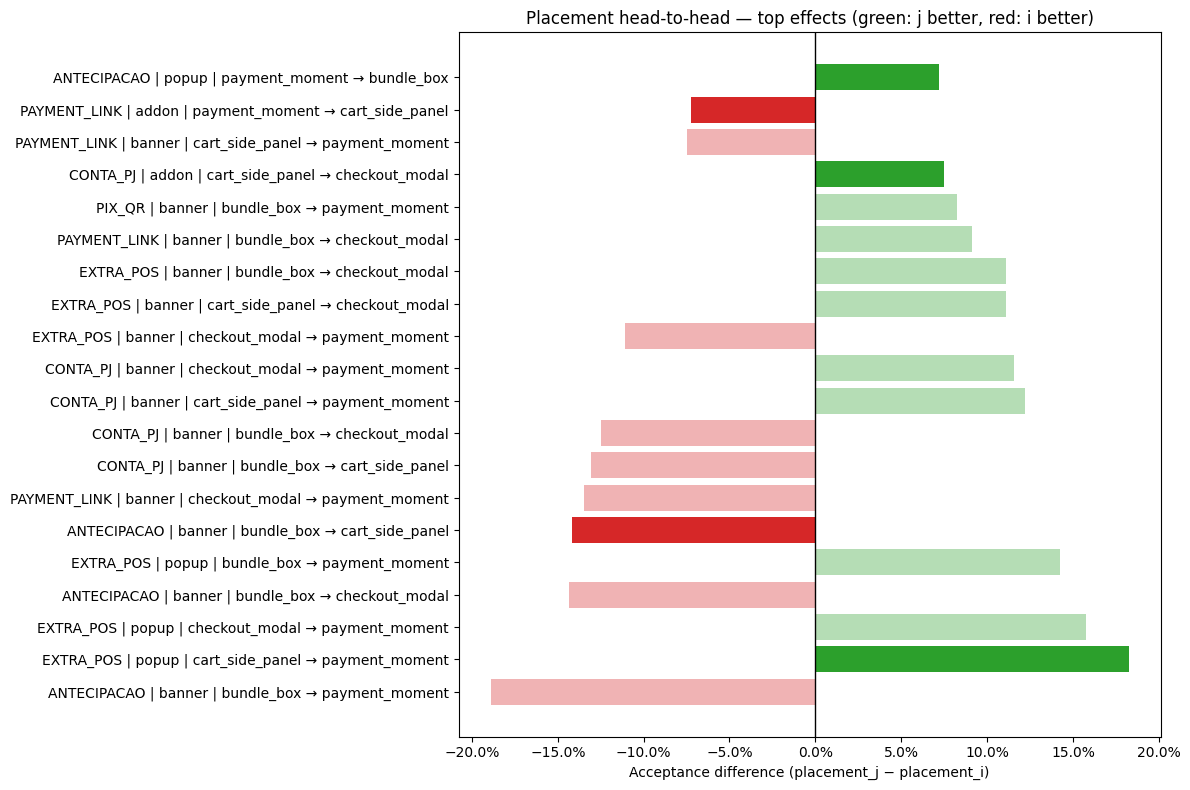

In [33]:
t = tests_df.copy()
t["delta"] = t["prob_success_placement_j"] - t["prob_success_placement_i"]
t["sig"] = t["pvalue"] < 0.05
t["label"] = (t["addon"] + " | " + t["incentive_type"] + " | " +
              t["placement_i"] + " → " + t["placement_j"])

# top 20 by |effect|
t = t.reindex(t["delta"].abs().sort_values(ascending=False).index).head(20)

fig, ax = plt.subplots(figsize=(12, 8))
colors = np.where(t["delta"] > 0, "tab:green", "tab:red")

bars = ax.barh(t["label"].values, t["delta"].values, color=colors)

# set alpha per bar
for bar, sig in zip(bars, t["sig"].values):
    bar.set_alpha(1.0 if sig else 0.35)

ax.axvline(0, color="k", lw=1)
ax.set_xlabel("Acceptance difference (placement_j − placement_i)")
ax.set_title("Placement head-to-head — top effects (green: j better, red: i better)")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout(); plt.show()

#### 1.1.4. Incentive ROI & profit frontier
    - Which incentives pay for themselves?
    - Where is money being wasted?

In [35]:
roi = df_cart_incentives.groupby(['candidate_addon', 'incentive_variant'])\
                        .agg(exposures=("incentive_id", "size"),
                             accept_rate=("accepted","mean"),
                             margin_if_accepted= ("margin_if_accepted", "mean"),
                             incentive_cost_if_accepted = ("incentive_cost_if_accepted", "mean"))\
                        .reset_index()
roi["expected_profit_per_1000"] = 1000* (roi["accept_rate"] * (roi['margin_if_accepted'] - roi['incentive_cost_if_accepted']))

In [37]:
boot_rows=[]
for (addon, variant), g in df_cart_incentives.groupby(['candidate_addon', 'incentive_variant']):
    profits = g['accepted'] * (g['margin_if_accepted'] - g['incentive_cost_if_accepted'])
    lo, hi = bootstrap_ci(profits, iters=500, stat_fn = lambda x: 1000*np.mean(x), alpha =0.05)
    boot_rows.append({
        "candidate_addon": addon,
        "incentive_variant": variant,
        "profit_per_1000_lo":lo,
        "profit_per_1000_hi":hi,
        "n": len(g)})
roi_ci = pd.DataFrame(boot_rows)
roi = roi.merge(roi_ci, on = ["candidate_addon", "incentive_variant"], how = "left").sort_values("expected_profit_per_1000", ascending = False)


In [38]:
roi

,candidate_addon,incentive_variant,exposures,accept_rate,margin_if_accepted,incentive_cost_if_accepted,expected_profit_per_1000,profit_per_1000_lo,profit_per_1000_hi,n
0,ANTECIPACAO,antec_discount_30bps,1292,0.089783,80.0,18.0,5566.563467,4654.798762,6478.328173,1292
5,EXTRA_POS,free_shipping,405,0.069136,100.0,20.0,5530.864198,3555.555556,7506.172840,405
1,ANTECIPACAO,copy_reminder_antec,1357,0.046426,80.0,0.0,3714.075166,2888.725129,4629.329403,1357
4,EXTRA_POS,copy_reminder_extra,397,0.035264,100.0,0.0,3526.448363,2015.113350,5289.672544,397
8,PIX_QR,copy_reminder_pix,2448,0.067810,50.0,0.0,3390.522876,2930.453431,3911.866830,2448
9,PIX_QR,pix_free_first_100,2451,0.088535,50.0,12.0,3364.341085,2930.232558,3868.604651,2451
7,PAYMENT_LINK,link_zero_fee_first_10,2386,0.100587,40.0,8.0,3218.776194,2816.429170,3674.769489,2386
6,PAYMENT_LINK,copy_reminder_link,2447,0.069473,40.0,0.0,2778.912955,2402.942378,3171.230078,2447
2,CONTA_PJ,copy_reminder_conta,1227,0.070905,30.0,0.0,2127.139364,1687.041565,2653.422983,1227
3,CONTA_PJ,monthly_fee_waived_3m,1172,0.094710,30.0,15.0,1420.648464,1177.474403,1676.621160,1172


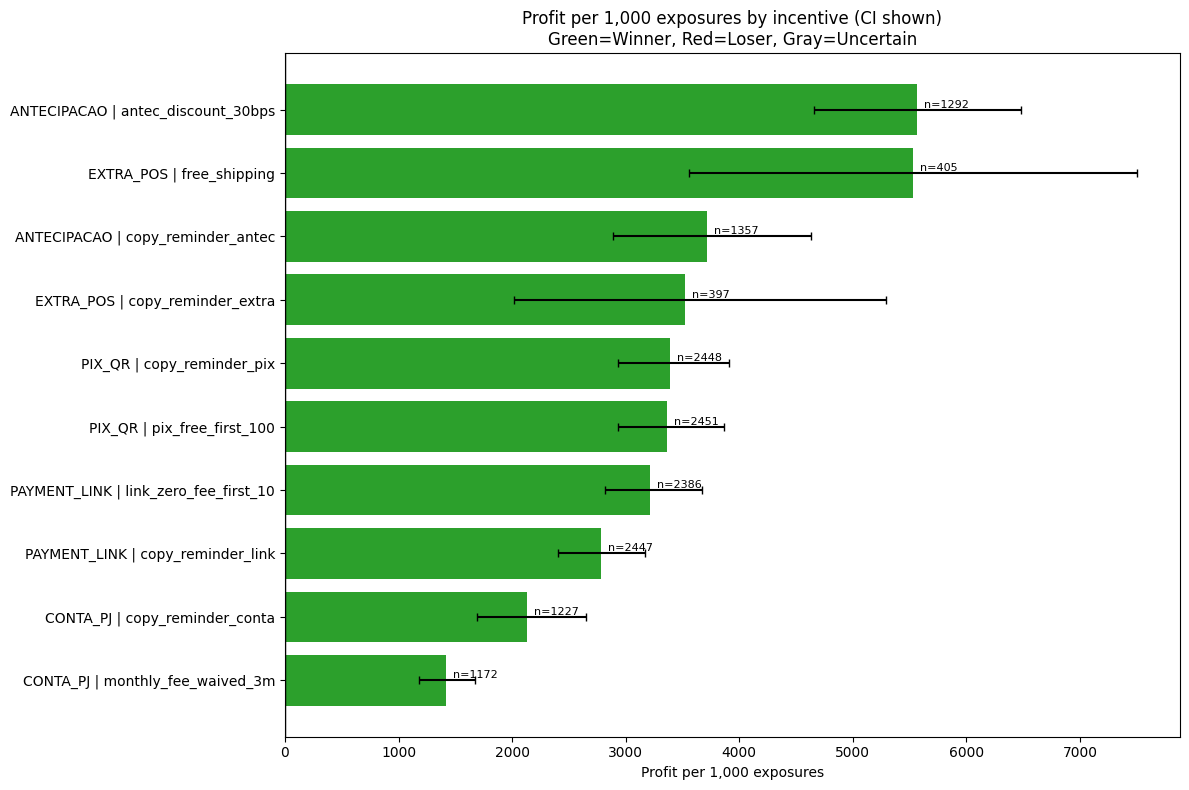

In [44]:
roi_plot = roi.copy()

# Handle either column name
profit_col = "expected_profit_per_1000" if "expected_profit_per_1000" in roi_plot.columns else "profit_per_1000"
lo_col = "profit_per_1000_lo"
hi_col = "profit_per_1000_hi"

# Label + status
roi_plot["label"] = roi_plot["candidate_addon"] + " | " + roi_plot["incentive_variant"]
def classify(row):
    if row[hi_col] <= 0: return "Loser"
    if row[lo_col] >= 0: return "Winner"
    return "Uncertain"
roi_plot["status"] = roi_plot.apply(classify, axis=1)

# Sort: worst to best (so the red ones pile at bottom/top clearly)
roi_plot = roi_plot.sort_values(profit_col)

# Colors by status
color_map = {"Winner": "tab:green", "Uncertain": "tab:gray", "Loser": "tab:red"}
colors = roi_plot["status"].map(color_map).values

# yerr from CI
yerr = np.vstack([
    roi_plot[profit_col] - roi_plot[lo_col],
    roi_plot[hi_col] - roi_plot[profit_col]
])

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(roi_plot["label"].values, roi_plot[profit_col].values, xerr=yerr, capsize=3, color=colors)

# annotate sample sizes
for i, (val, n) in enumerate(zip(roi_plot[profit_col].values, roi_plot["n"].values)):
    ax.text(val, i, f"  n={int(n)}", va="bottom", ha="left", fontsize=8)

ax.axvline(0, color="k", lw=1)
ax.set_title("Profit per 1,000 exposures by incentive (CI shown)\nGreen=Winner, Red=Loser, Gray=Uncertain")
ax.set_xlabel("Profit per 1,000 exposures")
# Optional: currency formatting (assumes values are in your currency units)
# ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))

plt.tight_layout()
plt.show()

#### 1.1.5. Segment Hetereogeneity
    - Who responds better?
    - Which merchant segments show bigger uplifts?
    

In [47]:
segment_dimentions = ["mcc","sales_channel","kyc_tier","legal_form","city_size_band","uf",
                      "has_pix_enabled","has_payment_link_enabled","has_antecipacao_enabled","has_conta_pj"]

In [50]:
merch_carts_incs.columns

Index(['incentive_id', 'cart_id', 'merchant_id', 'cart_timestamp', 'placement',
       'incentive_type', 'candidate_addon', 'incentive_variant', 'clicked',
       'accepted', 'incentive_cost_if_accepted', 'margin_if_accepted',
       'cart_products', 'cart_quantities', 'cart_unit_prices', 'cart_value',
       'funnel_step', 'device_type', 'payment_finalized',
       'payment_method_selected', 'merchant_cart_id', 'primary_product',
       'payment_finalized_cevents', 'cart_value_cevents',
       'device_type_cevents', 'payment_method_selected_cevents',
       'funnel_step_cevents', 'timestamp_cevents', 'legal_form', 'mcc', 'uf',
       'sales_channel', 'preferred_contact_channel', 'onboarding_date',
       'kyc_tier', 'employee_count_band', 'city_size_band', 'has_pix_enabled',
       'has_payment_link_enabled', 'has_antecipacao_enabled', 'has_conta_pj',
       'eligible_incentive', 'treatment', 'is_discount'],
      dtype='object')

In [ ]:
rows = []
for dim in segment_dimentions:
    for val, g in merch_carts_incs.groupby(dim):
        if len(g) < 200: continue
        t = g[g["treatment"] == 1]; c = g[g["treatment"] == 0]
        if len(t) == 0 or len(c) == 0: continue
        ate=t["accepted"].mean() - c["accepted"].mean() #average treatment effect(uplift in percentage points)
        rows.append({"segment":dim,
                     "value":val,
                     "n": len(g),
                     "attach_treated": t['accepted'].mean(),
                     "attach_control":c["accepted"].mean(),
                     "ate_attach_pp": ate})

In [55]:
seg_uplift = pd.DataFrame(rows).sort_values(["segment","ate_attach_pp" ], ascending=[True, False])

In [56]:
seg_uplift

,segment,value,n,attach_treated,attach_control,ate_attach_pp
18,city_size_band,small,4600,0.092433,0.060593,0.031840
17,city_size_band,medium,7182,0.092072,0.061890,0.030182
16,city_size_band,large,3800,0.092962,0.070148,0.022815
34,has_antecipacao_enabled,1,5430,0.094290,0.061777,0.032513
33,has_antecipacao_enabled,0,10152,0.091396,0.064409,0.026987
35,has_conta_pj,0,6000,0.106101,0.062668,0.043433
36,has_conta_pj,1,9582,0.083582,0.063982,0.019600
32,has_payment_link_enabled,1,7457,0.099863,0.062336,0.037528
31,has_payment_link_enabled,0,8125,0.085658,0.064556,0.021102
29,has_pix_enabled,0,6620,0.099237,0.062481,0.036755
